# Inspiration

- Basic Keras implementation: https://www.kaggle.com/bguberfain/naive-keras

- High-level image segmentation example: https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef

- Even more high-level example: https://towardsdatascience.com/semantic-segmentation-with-deep-learning-a-guide-and-code-e52fc8958823




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split


# Data loading & processing

In [2]:
input_folder = join('input')
imgs_idx = list(range(1, 17))

df_mask_train = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask_train['img'].map(lambda s: s.split('_')[0]).unique()
print("There are %d unique images and %d unique cars in the train set" % (len(df_mask_train),len(ids_train)))


df_mask_test = pd.read_csv(join(input_folder, 'sample_submission.csv'), usecols=['img'])
ids_test = df_mask_test['img'].map(lambda s: s.split('_')[0]).unique()
print("There are %d unique images and %d unique cars in the test set" % (len(df_mask_test),len(ids_test)))

There are 5088 unique images and 318 unique cars in the train set
There are 100064 unique images and 6254 unique cars in the test set


In [36]:
load_img = lambda im, idx: imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
load_test_img = lambda im, idx: imread(join(input_folder, 'test', '{}_{:02d}.jpg'.format(im, idx)))

# Changing image dimensions from 1280x1918 -> 1280x1920 -> 320x480
def downscale(im):
    im = cv2.copyMakeBorder(im,0,0,1,1,cv2.BORDER_REPLICATE)
    return cv2.resize(im, (0,0), fx=0.25, fy=0.25)

# Changing image dimensions from 320x480 -> 1280x1920 -> 1280x1918
def upscale(im):
    im = cv2.resize(im, (0,0), fx=4, fy=4)
    return im[:,1:-1]

IMG_HEIGHT, IMG_WIDTH = load_img(ids_train[0], 1).shape[:2]
SCALE_FACTOR = 4

print("Dimension of each train image is", load_img(ids_train[0], 1).shape)
print("Dimension of each test image is", load_test_img(ids_test[0], 1).shape)

Dimension of each train image is (1280, 1918, 3)
Dimension of each test image is (1280, 1918, 3)


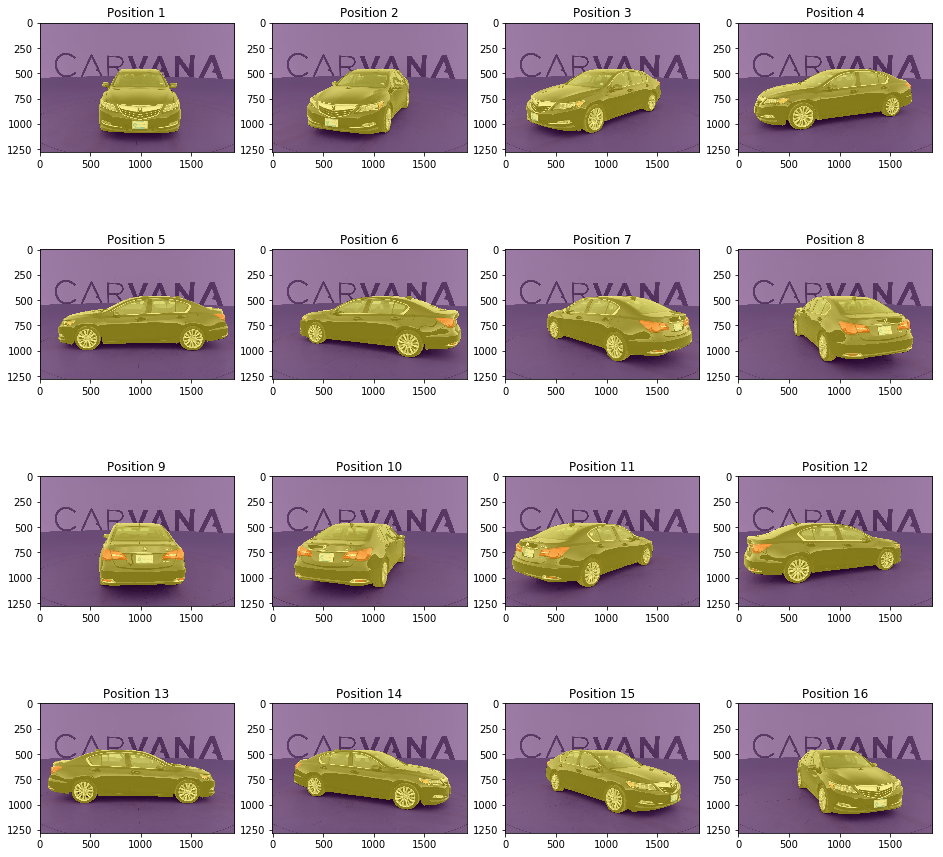

In [4]:
# Let's display a single car and mask

fig, ax = plt.subplots(4,4, figsize=(16, 16))
ax = ax.ravel()

for i in imgs_idx:
    ax[i-1].imshow(load_img(ids_train[0], i))
    ax[i-1].imshow(load_mask(ids_train[0], i), alpha = 0.5)
    ax[i-1].set_title('Position {}'.format(i))

Seems like there is a lot of rotational symmetry e.g. #2 and #17, although the pictures are not exact copies of each other (you can see from the background text)

In [6]:
# Preprocessing - loading all the training images, downscaling and concatenating into one 4D array

num_train = len(ids_train)

X = np.empty((num_train*16, 320, 480, 3), dtype=np.float32)
y = np.empty((num_train*16, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train*16) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        for j in imgs_idx:
            X[i*16+j-1, ...] = downscale(load_img(img_id, j)) / 255.
            y_temp = downscale(load_mask(img_id, j)) / 255.
            y[i*16+j-1] = y_temp[..., np.newaxis]
            bar.update()
                                                                   
#norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Attempt 1 - Naive

This is my first attempt - I'll implement a basic autoencoder-like architecture with few layers. 

In [8]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

Using TensorFlow backend.


In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout
from keras.models import Model, Sequential
from keras import backend as K

model = Sequential()

model.add (Conv2D(16, 3, activation='relu', padding='same', input_shape=(320,480, 3) ))
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )

model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(16, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 480, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 240, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 80, 120, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 120, 64)       18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 60, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 60, 64)        36928     
__________

Train on 4070 samples, validate on 1018 samples
Epoch 1/10
 - 67s - loss: -8.1652e-01 - acc: 0.9578 - dice_coef: 0.8810 - val_loss: -9.0759e-01 - val_acc: 0.9781 - val_dice_coef: 0.9422
Epoch 2/10
 - 62s - loss: -9.3076e-01 - acc: 0.9834 - dice_coef: 0.9556 - val_loss: -9.4325e-01 - val_acc: 0.9859 - val_dice_coef: 0.9646
Epoch 3/10
 - 62s - loss: -9.4979e-01 - acc: 0.9876 - dice_coef: 0.9678 - val_loss: -9.5331e-01 - val_acc: 0.9881 - val_dice_coef: 0.9711
Epoch 4/10
 - 62s - loss: -9.6071e-01 - acc: 0.9901 - dice_coef: 0.9748 - val_loss: -9.6644e-01 - val_acc: 0.9913 - val_dice_coef: 0.9784
Epoch 5/10
 - 62s - loss: -9.6269e-01 - acc: 0.9905 - dice_coef: 0.9761 - val_loss: -9.6498e-01 - val_acc: 0.9908 - val_dice_coef: 0.9779
Epoch 6/10
 - 62s - loss: -9.6512e-01 - acc: 0.9912 - dice_coef: 0.9779 - val_loss: -8.5755e-01 - val_acc: 0.9673 - val_dice_coef: 0.9154
Epoch 7/10
 - 62s - loss: -9.6503e-01 - acc: 0.9911 - dice_coef: 0.9776 - val_loss: -9.7227e-01 - val_acc: 0.9926 - val_dice

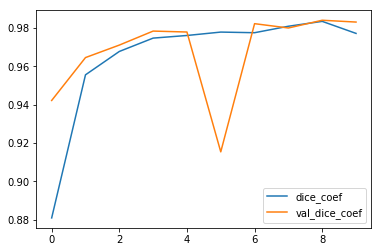

In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=5, verbose=2) #, 
                    #callbacks=[keras_utils.TqdmProgressCallback()])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('naive_model.h5')

# Attempt 2 - Naive with skip connections

Adding in the following elements:
- skip connections
- transposed convolutions instead of upsampling. 
- learning rate decay

In [21]:
from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

In [25]:
from keras.layers import Input, Dense, Add
from keras.models import Model
from keras.layers.merge import concatenate

# Input
inputs = Input(shape=(320, 480, 3))

# c = convolution, p = pooling, s = adding, u = unpooling

# Encoder
c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
p1 = MaxPooling2D((2, 2), padding='same') (c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
p2 = MaxPooling2D((2, 2), padding='same') (c2)

c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
p3 = MaxPooling2D((2, 2), padding='same') (c3)

# Decoder with skip connections
c4 = Conv2D(64, 3, activation='relu', padding='same')(p3)
u1 = Conv2DTranspose (64, (2, 2), strides=(2, 2), padding='same') (c4)
s1 = concatenate([u1, c3])

c5 = Conv2D(32, 3, activation='relu', padding='same')(u1)
s2 = concatenate([c5, p2])
u2 = Conv2DTranspose (32, (2, 2), strides=(2, 2), padding='same') (s2)

c6 = Conv2D(16, 3, activation='relu', padding='same')(u2)
s3 = concatenate([c6, p1])
u3 = Conv2DTranspose (16, (2, 2), strides=(2, 2), padding='same') (s3)

c7 = Conv2D(16, 3, activation='relu', padding='same') (u3)

final = Conv2D(1, 1, activation='sigmoid', padding='same')(c7)

model = Model(inputs=inputs, outputs=final)

# This creates a model that includes
# the Input layer and intermediate layers

model.compile(Adam(1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 320, 480, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 160, 240, 16) 0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 160, 240, 32) 4640        max_pooling2d_28[0][0]           
__________________________________________________________________________________________________
max_poolin

Train on 4070 samples, validate on 1018 samples
Epoch 1/20
 - 84s - loss: -8.0072e-01 - acc: 0.9546 - dice_coef: 0.8706 - val_loss: -8.7479e-01 - val_acc: 0.9713 - val_dice_coef: 0.9158
Epoch 2/20
 - 81s - loss: -9.2986e-01 - acc: 0.9831 - dice_coef: 0.9559 - val_loss: -9.5054e-01 - val_acc: 0.9875 - val_dice_coef: 0.9691
Epoch 3/20
 - 81s - loss: -9.5464e-01 - acc: 0.9887 - dice_coef: 0.9715 - val_loss: -9.5583e-01 - val_acc: 0.9888 - val_dice_coef: 0.9724
Epoch 4/20
 - 81s - loss: -9.6274e-01 - acc: 0.9905 - dice_coef: 0.9766 - val_loss: -9.6777e-01 - val_acc: 0.9915 - val_dice_coef: 0.9795
Epoch 5/20
 - 82s - loss: -9.7182e-01 - acc: 0.9926 - dice_coef: 0.9821 - val_loss: -9.6566e-01 - val_acc: 0.9910 - val_dice_coef: 0.9788
Epoch 6/20
 - 81s - loss: -9.7411e-01 - acc: 0.9931 - dice_coef: 0.9836 - val_loss: -9.6947e-01 - val_acc: 0.9919 - val_dice_coef: 0.9807
Epoch 7/20
 - 81s - loss: -9.7508e-01 - acc: 0.9934 - dice_coef: 0.9842 - val_loss: -9.7432e-01 - val_acc: 0.9931 - val_dice

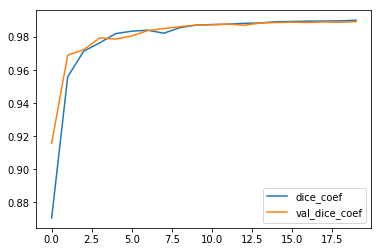

In [26]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=5, verbose=2, 
                   callbacks=[lrate])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('naive_skip_model.h5')

# Attempt 3 - UNet implementation

Thanks to https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 for the inspiration. 

Original paper is https://arxiv.org/pdf/1505.04597.pdf

In [ ]:
inputs = Input((320, 480, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef])
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=4, verbose=2) #, 
                    #callbacks=[keras_utils.TqdmProgressCallback()])

In [ ]:
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
model.save('my_model.h5')

In [ ]:
idx = 20
x = X_val[idx]

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax = ax.ravel()

ax[-3].imshow(x)
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

In [ ]:
plt.imshow(y_pred > 0.5, cmap='gray')

In [39]:
# def rle_encode(img):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     pixels = img.flatten('K')
#     pixels = np.concatenate([[0], pixels, [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)


def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Batch data generation

We need some kind of batch data generator to handle the large quantities of image data. 

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

# Submission

Text(0.5,1,'y_pred (test set) - final')

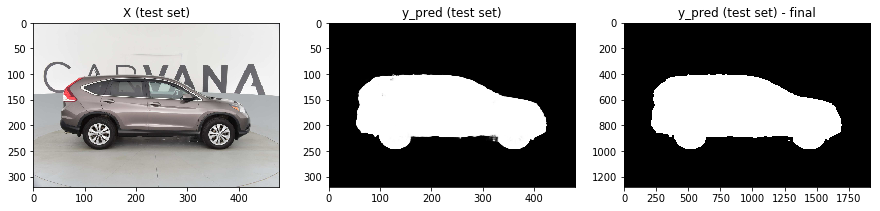

In [41]:
def prepare_img(im, idx):
    
    return (downscale(load_test_img(im, idx)) / 255.)
 
def predict_img_rle(X):
    y_pred = model.predict(X[None]).squeeze()
    
    # Upscale 4X on each axis
    y_pred = upscale(y_pred)
        
    # Encode a binary version of the image
    return rle_encode(np.float32(np.where(y_pred > 0.5, 1, 0)))

X = prepare_img(ids_test[66], 13)
y_pred = model.predict(X[None]).squeeze()

y_final = predict_img_rle(prepare_img(ids_test[66], 13))
y_final = rle_decode(y_final, (1280, 1918))

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax = ax.ravel()

ax[-3].imshow(X)
ax[-3].set_title('X (test set)')

ax[-2].imshow(y_pred, cmap='gray')
ax[-2].set_title('y_pred (test set)')

ax[-1].imshow(y_final, cmap='gray')
ax[-1].set_title('y_pred (test set) - final')

In [42]:
file = open("naive_submission2.csv", "w+")
file.write("img,rle_mask\n")

#num_test = 100
num_test = len(ids_test)

with tqdm_notebook(total=num_test*16) as bar:
    for i in ids_test[:num_test]:
        for j in imgs_idx:
            res = predict_img_rle(prepare_img(i, j))
            file.write('{}_{:02d}.jpg, {}\n'.format(i, j, res))
            bar.update()
            
# For some reason, the last image doesn't always get written, thus we need to flush. 
file.flush()

# Exploration

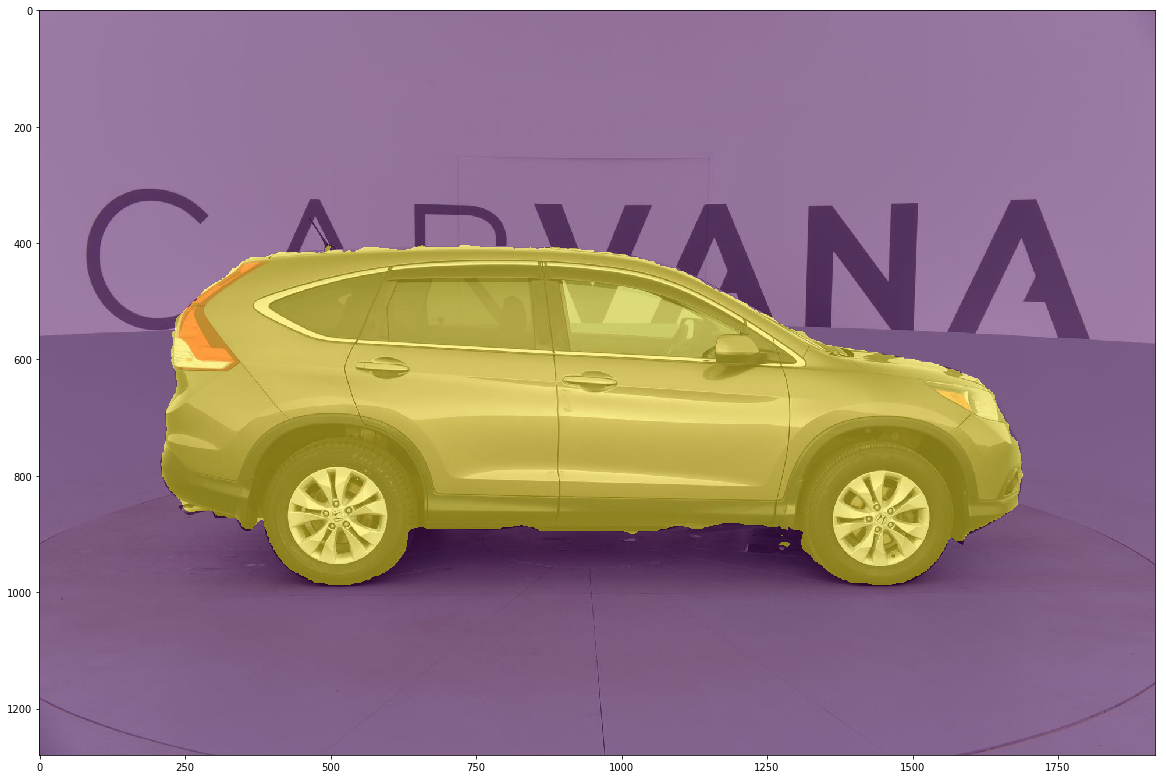

In [45]:
# Let's take a look at an expanded version of one of these

plt.figure(figsize=(20,20))

test = predict_img_rle(X)
plt.imshow(load_test_img(ids_test[66], 13))
plt.imshow(rle_decode(test, (1280, 1918)), alpha = 0.5)